# データ取得＋null埋め

In [48]:
!pip install lightgbm optuna

In [49]:
# prompt: googleのフォルダを全てロード

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [51]:
df=pd.read_csv("/content/drive/MyDrive/GCI_Winter/Titanic/train.csv")

In [52]:
df.head()

PassengerId  Perished  Pclass  \
0            1         1       3   
1            2         0       1   
2            3         0       3   
3            4         0       1   
4            5         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [53]:
# prompt: DataFrame df を使用: null情報を出力

# Check for null values in each column
df.isnull().sum()

PassengerId      0
Perished         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [54]:
# prompt: dfのカラムのタイプを出力

# dfのカラムのタイプを出力
df.dtypes

PassengerId      int64
Perished         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [55]:
# 欠損値の確認
missing_values = df.isnull().sum()

# 性別、年齢、運賃などの分布も簡単に確認
summary_stats = df.describe(include='all')

missing_values, summary_stats


(PassengerId      0
 Perished         0
 Pclass           0
 Name             0
 Sex              0
 Age            177
 SibSp            0
 Parch            0
 Ticket           0
 Fare             0
 Cabin          687
 Embarked         2
 dtype: int64,
         PassengerId    Perished      Pclass                     Name   Sex  \
 count    891.000000  891.000000  891.000000                      891   891   
 unique          NaN         NaN         NaN                      891     2   
 top             NaN         NaN         NaN  Braund, Mr. Owen Harris  male   
 freq            NaN         NaN         NaN                        1   577   
 mean     446.000000    0.616162    2.308642                      NaN   NaN   
 std      257.353842    0.486592    0.836071                      NaN   NaN   
 min        1.000000    0.000000    1.000000                      NaN   NaN   
 25%      223.500000    0.000000    2.000000                      NaN   NaN   
 50%      446.000000    1.000000  

In [56]:
# Age を中央値で補完
df['Age'].fillna(df['Age'].median(), inplace=True)

# Embarked を最頻値で補完
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# 前処理後の欠損値確認
missing_values_after = df.isnull().sum()
missing_values_after


<ipython-input-56-3d5c811c95ae>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
<ipython-input-56-3d5c811c95ae>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

PassengerId      0
Perished         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

# 明らかに不要なカラムを削除

In [57]:
# prompt: PassengerIdとCabinを削除

# PassengerIdとCabinを削除
df = df.drop(['PassengerId', 'Cabin'], axis=1)
df.head()

Perished  Pclass                                               Name  \
0         1       3                            Braund, Mr. Owen Harris   
1         0       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         0       3                             Heikkinen, Miss. Laina   
3         0       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         1       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch            Ticket     Fare Embarked  
0    male  22.0      1      0         A/5 21171   7.2500        S  
1  female  38.0      1      0          PC 17599  71.2833        C  
2  female  26.0      0      0  STON/O2. 3101282   7.9250        S  
3  female  35.0      1      0            113803  53.1000        S  
4    male  35.0      0      0            373450   8.0500        S

# 特徴量検証＋作成

<Axes: xlabel='Age', ylabel='Fare'>

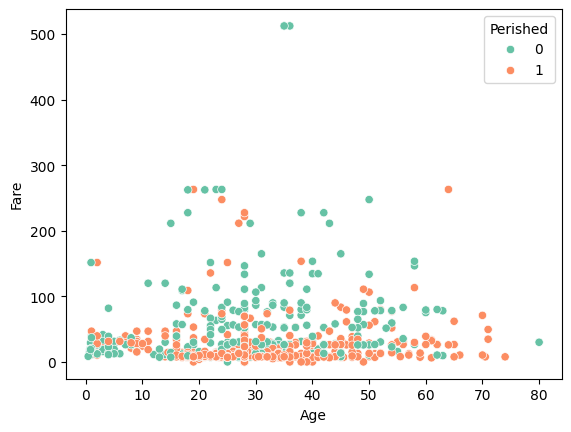

In [58]:
import seaborn as sns

# Age と Survived の関係を可視化
sns.scatterplot(x="Age", y="Fare",
                     hue="Perished", palette="Set2",
                     sizes=(20, 200), hue_norm=(0, 7),
                     legend="full", data=df)

<ipython-input-59-7ca675b85c54>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_probability_by_fare = df.groupby(fare_groups)['Perished'].mean()


Fare
(0, 25]       0.293358
(25, 50]      0.419540
(50, 75]      0.555556
(75, 100]     0.795455
(100, 125]    0.733333
(125, 150]    0.888889
(150, 175]    0.666667
(175, 200]         NaN
(200, 225]    0.600000
(225, 250]    0.666667
(250, 275]    0.666667
(275, 300]         NaN
(300, 325]         NaN
(325, 350]         NaN
(350, 375]         NaN
(375, 400]         NaN
(400, 425]         NaN
(425, 450]         NaN
(450, 475]         NaN
(475, 500]         NaN
(500, 525]    1.000000
Name: Perished, dtype: float64


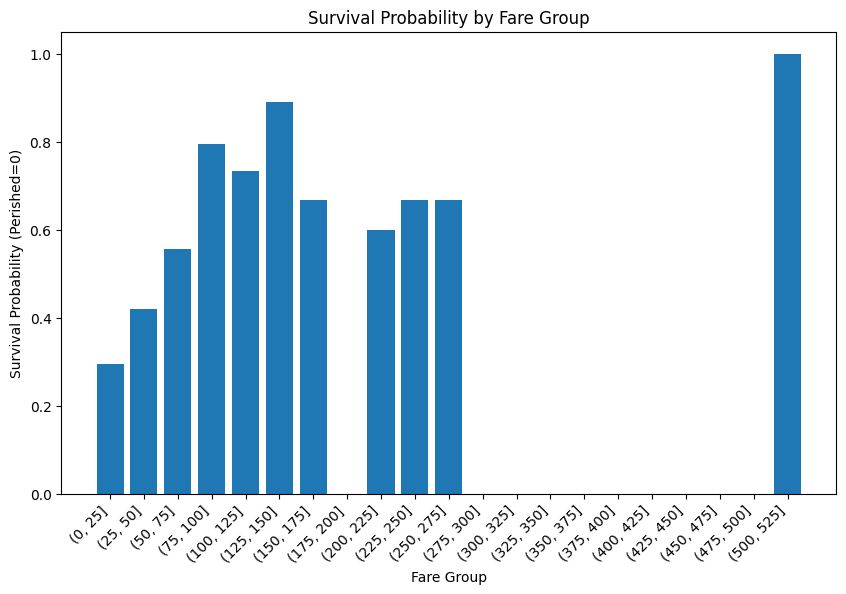

In [59]:
# prompt: Fareを１００ごとにグループ分けし、Perished＝０の確率を書いて
bin_range=25
# Fareを100ごとにグループ分けし、Perished=0の確率を計算
fare_groups = pd.cut(df['Fare'], bins=range(0, int(df['Fare'].max()) + bin_range, bin_range))
survival_probability_by_fare = df.groupby(fare_groups)['Perished'].mean()
survival_probability_by_fare = 1 - survival_probability_by_fare

# 結果を表示
print(survival_probability_by_fare)

# ヒストグラムで可視化
plt.figure(figsize=(10, 6))
plt.bar(survival_probability_by_fare.index.astype(str), survival_probability_by_fare.values)
plt.xlabel('Fare Group')
plt.ylabel('Survival Probability (Perished=0)')
plt.title('Survival Probability by Fare Group')
plt.xticks(rotation=45, ha='right')
plt.show()

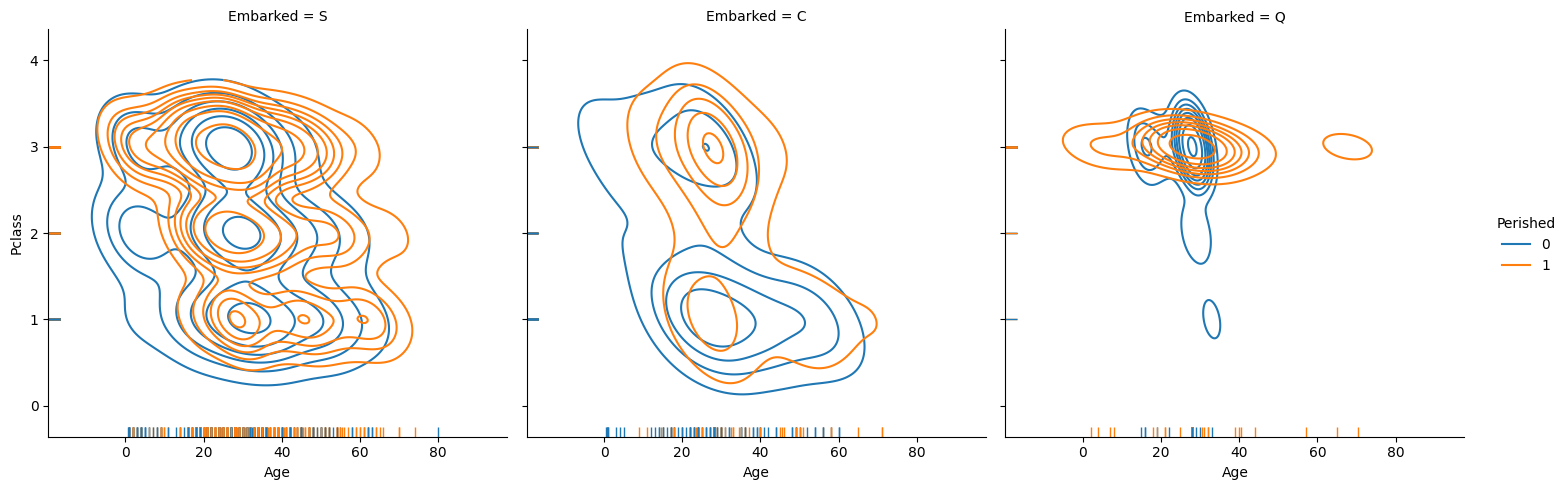

In [60]:
sns.displot(
    data=df, kind="kde", rug=True,
    x="Age", y="Pclass",
    col="Embarked", hue="Perished",
)

考察：Embarked＝QかつPclass!=３の時はPerished=0の可能性が高い  
この特徴量を読み込ませるために、Pclass×Embarkedの特徴量を使う（こういった時はSVMとかよりは、RFなどがいい気がする）

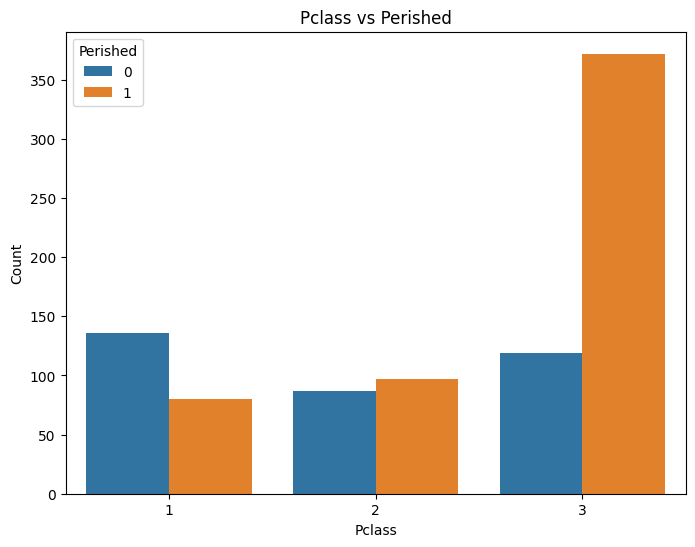

In [61]:
# prompt: pclassとPerishedで棒グラフを作って

# Pclass と Perished の関係を棒グラフで可視化
plt.figure(figsize=(8, 6))
sns.countplot(x='Pclass', hue='Perished', data=df)
plt.title('Pclass vs Perished')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.show()

S:移民や貴族など幅広い層が乗る  
C:貴族多い  
Q:移動に使われ、移民が多い

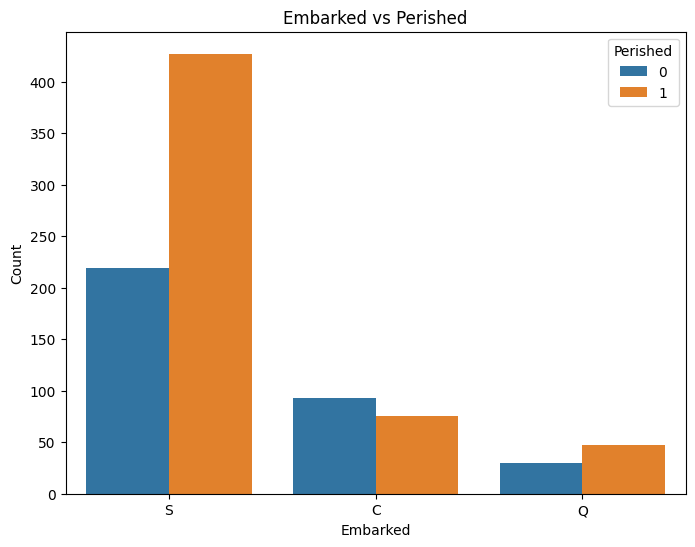

In [62]:
# prompt: Embarkedで区分し、Perishedの棒グラフを作って

# Embarkedで区分し、Perishedの棒グラフを作成
plt.figure(figsize=(8, 6))
sns.countplot(x='Embarked', hue='Perished', data=df)
plt.title('Embarked vs Perished')
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.show()

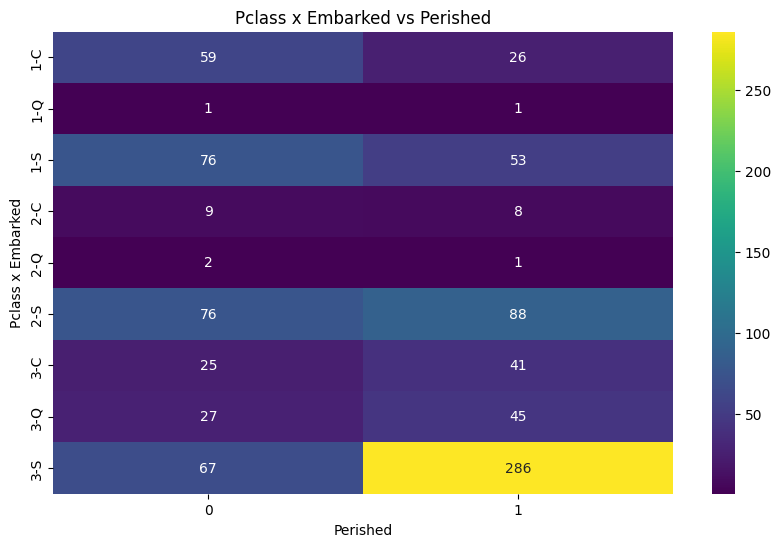

In [63]:
# prompt: Pclass×Embarkedで、Perished＝０とPerished＝１の数をsnsで表現

# Pclass と Embarked の組み合わせごとに Perished の数を集計
cross_tab = pd.crosstab(index=[df['Pclass'], df['Embarked']], columns=df['Perished'])

# Seaborn でヒートマップを作成
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='viridis')
plt.title('Pclass x Embarked vs Perished')
plt.xlabel('Perished')
plt.ylabel('Pclass x Embarked')
plt.show()

個人的にはS,Q,CなどによってPerishedの判断ができるとは思えない(サンプル数が少なかったり、分布がPclassごとに分かれているといった表現が正しそう)

In [64]:
# prompt: MRやMissなどの特徴量をnameから取得

# nameからMR, Miss, Mrsなどの敬称を取得する関数
def extract_title(name):
  if 'Mr.' in name:
    return 'Mr'
  elif 'Miss.' in name:
    return 'Miss'
  elif 'Mrs.' in name:
    return 'Mrs'
  elif 'Master.' in name:
    return 'Master'
  else:
    return 'Other'

# 新しい列'Title'を作成し、nameから敬称を抽出
df['Title'] = df['Name'].apply(extract_title)

# 'Title'列の値を確認
print(df['Title'].value_counts())

# 必要であれば、'Title'列を数値に変換
# 例：
# title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Other': 5}
# df['Title'] = df['Title'].map(title_mapping)

Title
Mr        517
Miss      182
Mrs       125
Master     40
Other      27
Name: count, dtype: int64


            mean  count
Title                  
Master  0.425000     40
Miss    0.302198    182
Mr      0.843327    517
Mrs     0.208000    125
Other   0.555556     27


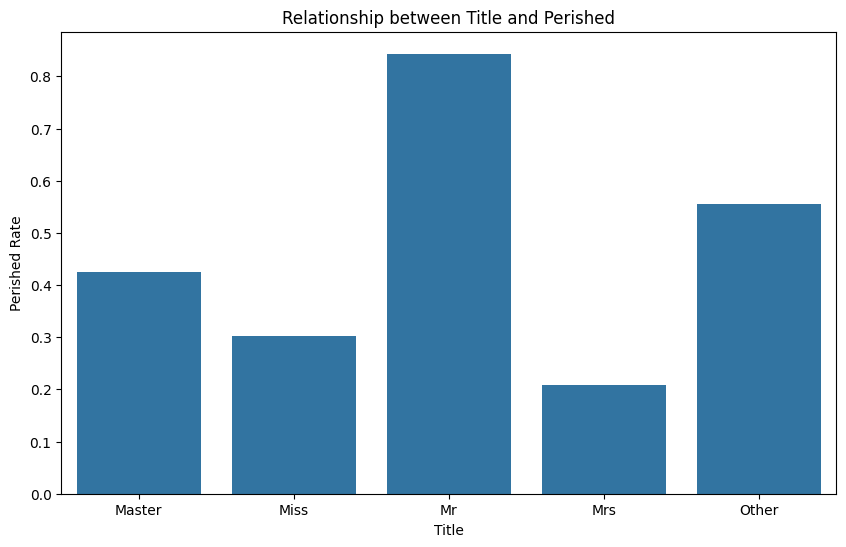

In [65]:
# prompt: IitleごとにPerishedとの関係性を取得

# Title ごとに Perished との関係性を集計
title_perished_relation = df.groupby('Title')['Perished'].agg(['mean', 'count'])

# 結果を表示
print(title_perished_relation)

# Title ごとに Perished の割合を棒グラフで可視化
plt.figure(figsize=(10, 6))
sns.barplot(x=title_perished_relation.index, y=title_perished_relation['mean'])
plt.xlabel('Title')
plt.ylabel('Perished Rate')
plt.title('Relationship between Title and Perished')
plt.show()

In [66]:
# prompt: MrやMissから既婚か否かを区別し、既婚の方で単身で行った人の割合を教えて（PassengerIDはない）。また、結婚か否か(or不明化)×単身か否かの２つを軸として、それぞれPerishedの人数を表示して

# 既婚と単身の関係を調べる
df['Married'] = 0
df.loc[df['Title'] == 'Mrs', 'Married'] = 1
df.loc[df['Title'] == 'Mr', 'Married'] = 1

df['Alone'] = 0
df.loc[(df['SibSp'] == 0) & (df['Parch'] == 0), 'Alone'] = 1

# 既婚者で単身で乗った人の割合
married_alone = df[(df['Married'] == 1) & (df['Alone'] == 1)]
married_alone_ratio = len(married_alone) / len(df[df['Married'] == 1])

print(f"既婚者で単身で乗った人の割合: {married_alone_ratio:.2%}")

# 結婚か否か×単身か否か×Perishedのクロス集計
cross_tab_perished = pd.crosstab(index=[df['Married'], df['Alone']], columns=df['Perished'])
cross_tab_perished


既婚者で単身で乗った人の割合: 64.95%


Perished         0    1
Married Alone          
0       0       78   51
        1       84   36
1       0      101  124
        1       79  338

In [67]:
# prompt: TitleがMasterの人のAlone・not AloneでのPerished＝０，１の人数を教えて

# TitleがMasterで、Alone/not AloneでPerishedが0, 1の人数を取得
master_alone_perished = df[(df['Title'] == 'Master') & (df['Alone'] == 1)]['Perished'].value_counts()
master_not_alone_perished = df[(df['Title'] == 'Master') & (df['Alone'] == 0)]['Perished'].value_counts()


print("TitleがMasterでAloneの人数:")
print(master_alone_perished)
print("\nTitleがMasterでNot Aloneの人数:")
master_not_alone_perished


TitleがMasterでAloneの人数:
Series([], Name: count, dtype: int64)

TitleがMasterでNot Aloneの人数:


Perished
0    23
1    17
Name: count, dtype: int64

In [68]:
!pip install ace-tools-open

In [69]:
df.head()

Perished  Pclass                                               Name  \
0         1       3                            Braund, Mr. Owen Harris   
1         0       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         0       3                             Heikkinen, Miss. Laina   
3         0       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         1       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch            Ticket     Fare Embarked Title  \
0    male  22.0      1      0         A/5 21171   7.2500        S    Mr   
1  female  38.0      1      0          PC 17599  71.2833        C   Mrs   
2  female  26.0      0      0  STON/O2. 3101282   7.9250        S  Miss   
3  female  35.0      1      0            113803  53.1000        S   Mrs   
4    male  35.0      0      0            373450   8.0500        S    Mr   

   Married  Alone  
0        1      0  
1        1      0  
2        0      1  
3        1      0  
4        1      1

In [70]:
# prompt: Sex,Married,Tickedを01ラベリングして

# Sexを01ラベリング
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Marriedを01ラベリング（既婚：1、未婚：0）
# これはすでに処理済みなので、コメントアウト
# df['Married'] = df['Married'].map({0: 0, 1: 1})
df.head()

Perished  Pclass                                               Name  Sex  \
0         1       3                            Braund, Mr. Owen Harris    0   
1         0       1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1   
2         0       3                             Heikkinen, Miss. Laina    1   
3         0       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1   
4         1       3                           Allen, Mr. William Henry    0   

    Age  SibSp  Parch            Ticket     Fare Embarked Title  Married  \
0  22.0      1      0         A/5 21171   7.2500        S    Mr        1   
1  38.0      1      0          PC 17599  71.2833        C   Mrs        1   
2  26.0      0      0  STON/O2. 3101282   7.9250        S  Miss        0   
3  35.0      1      0            113803  53.1000        S   Mrs        1   
4  35.0      0      0            373450   8.0500        S    Mr        1   

   Alone  
0      0  
1      0  
2      1  
3      0  
4      1

In [71]:
df.head()

Perished  Pclass                                               Name  Sex  \
0         1       3                            Braund, Mr. Owen Harris    0   
1         0       1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1   
2         0       3                             Heikkinen, Miss. Laina    1   
3         0       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1   
4         1       3                           Allen, Mr. William Henry    0   

    Age  SibSp  Parch            Ticket     Fare Embarked Title  Married  \
0  22.0      1      0         A/5 21171   7.2500        S    Mr        1   
1  38.0      1      0          PC 17599  71.2833        C   Mrs        1   
2  26.0      0      0  STON/O2. 3101282   7.9250        S  Miss        0   
3  35.0      1      0            113803  53.1000        S   Mrs        1   
4  35.0      0      0            373450   8.0500        S    Mr        1   

   Alone  
0      0  
1      0  
2      1  
3      0  
4      1

新たな特徴量を作成

In [72]:
# prompt: Fareをpd.qcutで値段の降順に数値でクラス分けし、Perished=0,1の人数+perished=1の割合+totalの人数

# Fareをpd.qcutで値段の降順に数値でクラス分け
df['Fare_Class'] = pd.qcut(df['Fare'], q=6, labels=False)

# Fare_ClassごとにPerished=0,1の人数、Perished=1の割合、totalの人数を計算
fare_class_stats = df.groupby('Fare_Class')['Perished'].agg(['sum', 'count'])
fare_class_stats['Perished_Ratio'] = fare_class_stats['sum'] / fare_class_stats['count']
fare_class_stats = fare_class_stats.rename(columns={'sum': 'Perished_Count', 'count': 'Total_Count'})

fare_class_stats

Perished_Count  Total_Count  Perished_Ratio
Fare_Class                                             
0                      124          156        0.794872
1                      123          152        0.809211
2                       88          139        0.633094
3                       84          149        0.563758
4                       85          146        0.582192
5                       45          149        0.302013

In [73]:
df=df.drop(columns=["Fare_Class"])
df.head()

Perished  Pclass                                               Name  Sex  \
0         1       3                            Braund, Mr. Owen Harris    0   
1         0       1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1   
2         0       3                             Heikkinen, Miss. Laina    1   
3         0       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1   
4         1       3                           Allen, Mr. William Henry    0   

    Age  SibSp  Parch            Ticket     Fare Embarked Title  Married  \
0  22.0      1      0         A/5 21171   7.2500        S    Mr        1   
1  38.0      1      0          PC 17599  71.2833        C   Mrs        1   
2  26.0      0      0  STON/O2. 3101282   7.9250        S  Miss        0   
3  35.0      1      0            113803  53.1000        S   Mrs        1   
4  35.0      0      0            373450   8.0500        S    Mr        1   

   Alone  
0      0  
1      0  
2      1  
3      0  
4      1

In [74]:
df=df.drop(columns=["Name","Ticket","Embarked","Title"])
df.head()

Perished  Pclass  Sex   Age  SibSp  Parch     Fare  Married  Alone
0         1       3    0  22.0      1      0   7.2500        1      0
1         0       1    1  38.0      1      0  71.2833        1      0
2         0       3    1  26.0      0      0   7.9250        0      1
3         0       1    1  35.0      1      0  53.1000        1      0
4         1       3    0  35.0      0      0   8.0500        1      1

In [103]:
df=pd.read_csv("/content/drive/MyDrive/GCI_Winter/Titanic/train.csv")
df=df.drop(columns=["Name","PassengerId","Cabin","Ticket"])#Sex,Embarkedを数値変換

# Sexを数値変換 (male: 0, female: 1)
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Embarkedを数値変換 (S: 0, C: 1, Q: 2)
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
df["Age"]=df["Age"].fillna(df["Age"].median())
df["Fare"]=df["Fare"].fillna(df["Fare"].median())
df["Embarked"]=df["Embarked"].fillna(df["Embarked"].median())
df.head()

Perished  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0         1       3    0  22.0      1      0   7.2500       0.0
1         0       1    1  38.0      1      0  71.2833       1.0
2         0       3    1  26.0      0      0   7.9250       0.0
3         0       1    1  35.0      1      0  53.1000       0.0
4         1       3    0  35.0      0      0   8.0500       0.0

In [104]:
df.isnull().sum()

Perished    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

# モデル学習(k-fold)

In [105]:
# prompt: dfからPerishedを予測するタスクにおいて、ｋ－ふぉｌｄによって５回分fitさせたい

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Perishedを目的変数、それ以外を説明変数として抽出
X = df.drop('Perished', axis=1)
y = df['Perished']

# KFoldオブジェクトを作成（5分割）
def train_model(model,train_num=10):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # 各foldで学習と評価を行う
    for _ in range(train_num):
      for fold, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # ロジスティック回帰モデルをインスタンス化
        model = LogisticRegression(max_iter=1000)

        # モデルを学習
        model.fit(X_train, y_train)

        # 検証データで予測
        y_pred = model.predict(X_val)

        # 精度を評価
        accuracy = accuracy_score(y_val, y_pred)
        print(f"Fold {fold+1}: Accuracy = {accuracy}")
    return model

In [106]:
# ロジスティック回帰モデルの構築と学習
from sklearn.linear_model import LogisticRegression
model_logistic = LogisticRegression(max_iter=1000)
model_logistic=train_model(model_logistic)

Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accu

In [107]:
from sklearn.tree import DecisionTreeClassifier

# 決定木モデルの構築と学習
tree_model = DecisionTreeClassifier(random_state=42)
tree_model=train_model(tree_model)

Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accu

In [108]:
# prompt: XGBClassifierで予測(eval_set=auc)

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# XGBoostモデルの構築と学習
xgb_model = XGBClassifier(random_state=42)
xgb_model=train_model(xgb_model)

Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accu

In [109]:
# prompt: KNeighborsClassifierで予測

from sklearn.neighbors import KNeighborsClassifier

for k in range(1, 11):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    _=train_model(knn_model)

Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accu

In [110]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(random_state=42)
model_dt=train_model(model_dt)

Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accu

In [111]:
# prompt: RandomForestClassifierで予測

from sklearn.ensemble import RandomForestClassifier

# ランダムフォレストモデルの構築と学習
rf_model = RandomForestClassifier(random_state=42)
rf_model=train_model(rf_model)

Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accu

In [112]:
# prompt: svmで予測

from sklearn.svm import SVC

svc_model=SVC()
svc_model=train_model(svc_model)

Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accu

In [113]:
# prompt: lgbのパラメーターチューニングをoptuna(cross-validation)にやらせて
import lightgbm as lgb
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# ... (Your existing code for data preprocessing) ...

# 説明変数と目的変数を定義
X = df.drop('Perished', axis=1)
y = df['Perished']

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 31, 255),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_val],
            num_boost_round=100
        )

        y_pred = model.predict(X_val)
        y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]
        scores.append(accuracy_score(y_val, y_pred_binary))

    return np.mean(scores)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best accuracy:', study.best_value)

# 最適なパラメータでモデルを学習
best_params = study.best_trial.params
lgb_model = lgb.LGBMClassifier(**best_params, random_state=0)
lgb_model=train_model(lgb_model)
# テストデータで予測 (テストデータの読み込みと前処理が必要)
# ...
# y_pred = model.predict(X_test)

[I 2024-11-15 01:47:57,913] A new study created in memory with name: no-name-6c10686d-7ff8-4d5c-9527-239febaffc5c


[LightGBM] [Info] Number of positive: 439, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.616573 -> initscore=0.475028
[LightGBM] [Info] Start training from score 0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:47:58,521] Trial 0 finished with value: 0.8260184545853996 and parameters: {'learning_rate': 0.021171361446526184, 'num_leaves': 220, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.5971068255418368, 'colsample_bytree': 0.6926520791476437, 'reg_alpha': 0.7786215565361994, 'reg_lambda': 0.559560711312504}. Best is trial 0 with value: 0.8260184545853996.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:47:59,070] Trial 1 finished with value: 0.8462306195467957 and parameters: {'learning_rate': 0.15189616050197932, 'num_leaves': 228, 'max_depth': 8, 'min_child_samples': 65, 'subsample': 0.8441668258420507, 'colsample_bytree': 0.9886703287886394, 'reg_alpha': 0.5244733692198135, 'reg_lambda': 0.4021938274236553}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:47:59,503] Trial 2 finished with value: 0.8226539451384095 and parameters: {'learning_rate': 0.24512481764879546, 'num_leaves': 72, 'max_depth': 8, 'min_child_samples': 92, 'subsample': 0.9694241337988586, 'colsample_bytree': 0.7907669381235986, 'reg_alpha': 0.05616155832907299, 'reg_lambda': 0.5572946521845243}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:47:59,994] Trial 3 finished with value: 0.8327600276191074 and parameters: {'learning_rate': 0.19141147270989164, 'num_leaves': 183, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.9379839926598159, 'colsample_bytree': 0.5326056998671161, 'reg_alpha': 0.11501536423071979, 'reg_lambda': 0.4796935929429752}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:00,481] Trial 4 finished with value: 0.819295712761283 and parameters: {'learning_rate': 0.11345322786828346, 'num_leaves': 249, 'max_depth': 8, 'min_child_samples': 86, 'subsample': 0.5280898304946748, 'colsample_bytree': 0.5385562056047988, 'reg_alpha': 0.26586016194009987, 'reg_lambda': 0.6180605947587302}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:00,941] Trial 5 finished with value: 0.8293766869625259 and parameters: {'learning_rate': 0.23818419008570407, 'num_leaves': 169, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.8991890661782511, 'colsample_bytree': 0.588073582121232, 'reg_alpha': 0.9664898403244226, 'reg_lambda': 0.7636327241837357}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:01,416] Trial 6 finished with value: 0.8372418555018518 and parameters: {'learning_rate': 0.06633895075099368, 'num_leaves': 173, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.9972398621694196, 'colsample_bytree': 0.7614348421207938, 'reg_alpha': 0.8691097165452747, 'reg_lambda': 0.6815333341764775}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:48:02,045] Trial 7 finished with value: 0.828253091456908 and parameters: {'learning_rate': 0.23002828721573873, 'num_leaves': 37, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.6021103168890725, 'colsample_bytree': 0.8264034718838776, 'reg_alpha': 0.00261911081296351, 'reg_lambda': 0.3595696545393895}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:02,536] Trial 8 finished with value: 0.8338773460548616 and parameters: {'learning_rate': 0.1644146532376682, 'num_leaves': 45, 'max_depth': 8, 'min_child_samples': 61, 'subsample': 0.6717768769983881, 'colsample_bytree': 0.641267868771515, 'reg_alpha': 0.10458922245633606, 'reg_lambda': 0.880877569883848}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:03,018] Trial 9 finished with value: 0.8204067541271733 and parameters: {'learning_rate': 0.053372667695441266, 'num_leaves': 124, 'max_depth': 8, 'min_child_samples': 61, 'subsample': 0.8322008812289945, 'colsample_bytree': 0.5630955195750849, 'reg_alpha': 0.3736760128491933, 'reg_lambda': 0.8315526355294711}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:03,588] Trial 10 finished with value: 0.8350009415604795 and parameters: {'learning_rate': 0.2948405814432078, 'num_leaves': 254, 'max_depth': 6, 'min_child_samples': 42, 'subsample': 0.7761452621892426, 'colsample_bytree': 0.9619724830755664, 'reg_alpha': 0.5776301350204259, 'reg_lambda': 0.016114765789345897}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:04,128] Trial 11 finished with value: 0.8383780051471973 and parameters: {'learning_rate': 0.10128053376645205, 'num_leaves': 200, 'max_depth': 5, 'min_child_samples': 40, 'subsample': 0.8567863759522294, 'colsample_bytree': 0.9894970395493706, 'reg_alpha': 0.6441179569149948, 'reg_lambda': 0.25123592510400594}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 439, number of negative: 273
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.616573 -> initscore=0.475028
[LightGBM] [Info] Start training from score 0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-15 01:48:04,847] Trial 12 finished with value: 0.8383717280773334 and parameters: {'learning_rate': 0.11733342880320832, 'num_leaves': 202, 'max_depth': 6, 'min_child_samples': 43, 'subsample': 0.8017130296804156, 'colsample_bytree': 0.9952150959938432, 'reg_alpha': 0.6250415548749181, 'reg_lambda': 0.24871736414535725}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 439, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.616573 -> initscore=0.475028
[LightGBM] [Info] Start training from score 0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:06,531] Trial 13 finished with value: 0.8361308141359614 and parameters: {'learning_rate': 0.11819617242002292, 'num_leaves': 123, 'max_depth': 3, 'min_child_samples': 43, 'subsample': 0.8615109498213723, 'colsample_bytree': 0.89453466029243, 'reg_alpha': 0.4308545349934152, 'reg_lambda': 0.18482757179915482}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 439, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.616573 -> initscore=0.475028
[LightGBM] [Info] Start training from score 0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:09,494] Trial 14 finished with value: 0.8361245370660976 and parameters: {'learning_rate': 0.1573844593505482, 'num_leaves': 221, 'max_depth': 5, 'min_child_samples': 73, 'subsample': 0.7149634707943613, 'colsample_bytree': 0.9003807971316559, 'reg_alpha': 0.7180534556794121, 'reg_lambda': 0.40279322551738567}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205

[I 2024-11-15 01:48:10,113] Trial 15 finished with value: 0.8406189190885694 and parameters: {'learning_rate': 0.08816452684685663, 'num_leaves': 156, 'max_depth': 7, 'min_child_samples': 34, 'subsample': 0.8743831211926522, 'colsample_bytree': 0.9144015273855919, 'reg_alpha': 0.5295002332492985, 'reg_lambda': 0.16709362754188412}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:10,667] Trial 16 finished with value: 0.8372230242922603 and parameters: {'learning_rate': 0.1916500083167643, 'num_leaves': 145, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.7223558703493502, 'colsample_bytree': 0.8925377182284783, 'reg_alpha': 0.498196042073906, 'reg_lambda': 0.00552605935744882}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:11,291] Trial 17 finished with value: 0.8395016006528154 and parameters: {'learning_rate': 0.07803303932468779, 'num_leaves': 107, 'max_depth': 10, 'min_child_samples': 32, 'subsample': 0.9103213304076972, 'colsample_bytree': 0.843695405988482, 'reg_alpha': 0.3301327234400857, 'reg_lambda': 0.14854251516163433}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:48:11,839] Trial 18 finished with value: 0.8406126420187056 and parameters: {'learning_rate': 0.13693782885486078, 'num_leaves': 93, 'max_depth': 7, 'min_child_samples': 72, 'subsample': 0.7668214458884139, 'colsample_bytree': 0.9313197349470344, 'reg_alpha': 0.20860233703922393, 'reg_lambda': 0.3570093628374102}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 439, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

[I 2024-11-15 01:48:12,358] Trial 19 finished with value: 0.7990898248697509 and parameters: {'learning_rate': 0.013469428407314216, 'num_leaves': 155, 'max_depth': 9, 'min_child_samples': 83, 'subsample': 0.8868029913872844, 'colsample_bytree': 0.7210807187934267, 'reg_alpha': 0.5040580148413939, 'reg_lambda': 0.1043355633405233}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:12,867] Trial 20 finished with value: 0.8170422446801833 and parameters: {'learning_rate': 0.18436926051108143, 'num_leaves': 216, 'max_depth': 7, 'min_child_samples': 100, 'subsample': 0.810902189083424, 'colsample_bytree': 0.847308687729493, 'reg_alpha': 0.7672041452466176, 'reg_lambda': 0.2829050546741949}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 439, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.616573 -> initscore=0.475028
[LightGBM] [Info] Start training from score 0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2024-11-15 01:48:13,456] Trial 21 finished with value: 0.837266963781307 and parameters: {'learning_rate': 0.1368056606762552, 'num_leaves': 89, 'max_depth': 7, 'min_child_samples': 70, 'subsample': 0.7691450816799571, 'colsample_bytree': 0.9395425308575087, 'reg_alpha': 0.22081163485082744, 'reg_lambda': 0.3910500626442583}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:14,102] Trial 22 finished with value: 0.8293892411022534 and parameters: {'learning_rate': 0.08334599725836613, 'num_leaves': 68, 'max_depth': 9, 'min_child_samples': 55, 'subsample': 0.67313948654028, 'colsample_bytree': 0.9334115837017304, 'reg_alpha': 0.5043879676838292, 'reg_lambda': 0.4590728494718722}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:14,656] Trial 23 finished with value: 0.8439897056054233 and parameters: {'learning_rate': 0.13379180181319517, 'num_leaves': 122, 'max_depth': 6, 'min_child_samples': 62, 'subsample': 0.743753974565534, 'colsample_bytree': 0.9395409423542814, 'reg_alpha': 0.2036968311250644, 'reg_lambda': 0.3385721642236267}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:15,267] Trial 24 finished with value: 0.8372606867114432 and parameters: {'learning_rate': 0.04976169681988872, 'num_leaves': 121, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.841854567414945, 'colsample_bytree': 0.8701374702267028, 'reg_alpha': 0.40111454063208496, 'reg_lambda': 0.29094599885093186}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 439, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.616573 -> initscore=0.475028
[LightGBM] [Info] Start training from score 0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:15,776] Trial 25 finished with value: 0.8428723871696692 and parameters: {'learning_rate': 0.14120408776176044, 'num_leaves': 147, 'max_depth': 6, 'min_child_samples': 62, 'subsample': 0.7171088200137934, 'colsample_bytree': 0.9658822873468053, 'reg_alpha': 0.32420099699321475, 'reg_lambda': 0.09571608944960906}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 439, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.616573 -> initscore=0.475028
[LightGBM] [Info] Start training from score 0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2024-11-15 01:48:16,329] Trial 26 finished with value: 0.8428598330299417 and parameters: {'learning_rate': 0.2147402927781753, 'num_leaves': 135, 'max_depth': 4, 'min_child_samples': 64, 'subsample': 0.661756543546856, 'colsample_bytree': 0.9692362203428496, 'reg_alpha': 0.2895911568102052, 'reg_lambda': 0.06955830332241084}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:16,902] Trial 27 finished with value: 0.8338773460548616 and parameters: {'learning_rate': 0.13304719839207974, 'num_leaves': 233, 'max_depth': 6, 'min_child_samples': 51, 'subsample': 0.6391102583732349, 'colsample_bytree': 0.9968571043759479, 'reg_alpha': 0.1658875088727566, 'reg_lambda': 0.9529140398942988}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:17,477] Trial 28 finished with value: 0.8316238779737619 and parameters: {'learning_rate': 0.1711957443731245, 'num_leaves': 191, 'max_depth': 5, 'min_child_samples': 83, 'subsample': 0.721957160781981, 'colsample_bytree': 0.7924973405338073, 'reg_alpha': 0.4307640780504771, 'reg_lambda': 0.21360667341134737}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:48:17,976] Trial 29 finished with value: 0.8293892411022534 and parameters: {'learning_rate': 0.14545389190557914, 'num_leaves': 106, 'max_depth': 4, 'min_child_samples': 77, 'subsample': 0.5331759438281827, 'colsample_bytree': 0.9545307121884475, 'reg_alpha': 0.30009761141549457, 'reg_lambda': 0.545327262256563}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:48:18,588] Trial 30 finished with value: 0.8428535559600778 and parameters: {'learning_rate': 0.20897534685468452, 'num_leaves': 163, 'max_depth': 6, 'min_child_samples': 62, 'subsample': 0.7333410943043797, 'colsample_bytree': 0.6694461114968089, 'reg_alpha': 0.34018994143376285, 'reg_lambda': 0.31853899003836106}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-11-15 01:48:19,225] Trial 31 finished with value: 0.8417425145941874 and parameters: {'learning_rate': 0.2676352673320894, 'num_leaves': 132, 'max_depth': 3, 'min_child_samples': 64, 'subsample': 0.679876280461706, 'colsample_bytree': 0.9641314622643837, 'reg_alpha': 0.26440215659416694, 'reg_lambda': 0.07494626678568299}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2024-11-15 01:48:20,930] Trial 32 finished with value: 0.8305191136777352 and parameters: {'learning_rate': 0.2158500358321325, 'num_leaves': 146, 'max_depth': 4, 'min_child_samples': 54, 'subsample': 0.6229042605989102, 'colsample_bytree': 0.9794101084829728, 'reg_alpha': 0.1955757865368628, 'reg_lambda': 0.08150184438827714}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:48:23,232] Trial 33 finished with value: 0.8428661100998054 and parameters: {'learning_rate': 0.17916817998831347, 'num_leaves': 69, 'max_depth': 4, 'min_child_samples': 67, 'subsample': 0.5643377959482504, 'colsample_bytree': 0.8775385278554867, 'reg_alpha': 0.4377260918598229, 'reg_lambda': 0.4518332548475613}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 439, number of negative: 273
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.616573 -> initscore=0.475028
[LightGBM] [Info] Start training from score 0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-15 01:48:24,546] Trial 34 finished with value: 0.8395016006528152 and parameters: {'learning_rate': 0.17225320691714618, 'num_leaves': 59, 'max_depth': 5, 'min_child_samples': 67, 'subsample': 0.5485656567988674, 'colsample_bytree': 0.874542306256095, 'reg_alpha': 0.4628736543121185, 'reg_lambda': 0.44513251170952617}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:25,193] Trial 35 finished with value: 0.8305191136777352 and parameters: {'learning_rate': 0.15187242185962296, 'num_leaves': 85, 'max_depth': 8, 'min_child_samples': 78, 'subsample': 0.5845866948293418, 'colsample_bytree': 0.8106019707550792, 'reg_alpha': 0.12606373809093896, 'reg_lambda': 0.5296298532201765}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:25,829] Trial 36 finished with value: 0.8215240725629276 and parameters: {'learning_rate': 0.1912763191205938, 'num_leaves': 105, 'max_depth': 9, 'min_child_samples': 91, 'subsample': 0.9300305131435114, 'colsample_bytree': 0.9253103917127533, 'reg_alpha': 0.566373595631854, 'reg_lambda': 0.6146013714665868}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:26,459] Trial 37 finished with value: 0.8305128366078713 and parameters: {'learning_rate': 0.10286117991955052, 'num_leaves': 181, 'max_depth': 5, 'min_child_samples': 48, 'subsample': 0.5055521562554164, 'colsample_bytree': 0.86392711931411, 'reg_alpha': 0.6724770084746188, 'reg_lambda': 0.6009302918863639}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:27,092] Trial 38 finished with value: 0.8327537505492437 and parameters: {'learning_rate': 0.12201679775699818, 'num_leaves': 239, 'max_depth': 3, 'min_child_samples': 59, 'subsample': 0.5812033975543995, 'colsample_bytree': 0.762955833244995, 'reg_alpha': 0.05197556635536549, 'reg_lambda': 0.6961787042074957}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:27,695] Trial 39 finished with value: 0.8417362375243236 and parameters: {'learning_rate': 0.18149121558032746, 'num_leaves': 32, 'max_depth': 4, 'min_child_samples': 57, 'subsample': 0.6948886631635995, 'colsample_bytree': 0.9492267802473052, 'reg_alpha': 0.35304570143475394, 'reg_lambda': 0.4679640777699068}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:28,280] Trial 40 finished with value: 0.8394702153034963 and parameters: {'learning_rate': 0.20021731107067903, 'num_leaves': 61, 'max_depth': 8, 'min_child_samples': 77, 'subsample': 0.7856756216311547, 'colsample_bytree': 0.9085201393348822, 'reg_alpha': 0.9286865461395796, 'reg_lambda': 0.3442484602794693}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:48:28,829] Trial 41 finished with value: 0.840631473228297 and parameters: {'learning_rate': 0.2528926021505149, 'num_leaves': 134, 'max_depth': 4, 'min_child_samples': 66, 'subsample': 0.6353057061736482, 'colsample_bytree': 0.972198979312131, 'reg_alpha': 0.2713656009436344, 'reg_lambda': 0.12925348616121418}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:29,435] Trial 42 finished with value: 0.8428723871696692 and parameters: {'learning_rate': 0.2191580143169648, 'num_leaves': 176, 'max_depth': 3, 'min_child_samples': 68, 'subsample': 0.7491094161005754, 'colsample_bytree': 0.9639439075811439, 'reg_alpha': 0.38897514058698146, 'reg_lambda': 0.4169517285579576}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:29,980] Trial 43 finished with value: 0.8350072186303434 and parameters: {'learning_rate': 0.16782930435583573, 'num_leaves': 176, 'max_depth': 3, 'min_child_samples': 68, 'subsample': 0.9630899061994953, 'colsample_bytree': 0.9992744455034962, 'reg_alpha': 0.39267453459865354, 'reg_lambda': 0.41182694857793267}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 439, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.616573 -> initscore=0.475028
[LightGBM] [Info] Start training from score 0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:30,474] Trial 44 finished with value: 0.8305128366078716 and parameters: {'learning_rate': 0.14937613672154132, 'num_leaves': 166, 'max_depth': 3, 'min_child_samples': 73, 'subsample': 0.7443190392062372, 'colsample_bytree': 0.9462691141989743, 'reg_alpha': 0.4359290697209281, 'reg_lambda': 0.424734012413251}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 439, number of negative: 274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615708 -> initscore=0.471371
[LightGBM] [Info] Start training from score 0.471371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:31,142] Trial 45 finished with value: 0.8417425145941874 and parameters: {'learning_rate': 0.2324382144749893, 'num_leaves': 208, 'max_depth': 6, 'min_child_samples': 60, 'subsample': 0.8177445990597811, 'colsample_bytree': 0.8889462627412208, 'reg_alpha': 0.5820039534922532, 'reg_lambda': 0.5742432619021861}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:31,765] Trial 46 finished with value: 0.83947649237336 and parameters: {'learning_rate': 0.12858809343224334, 'num_leaves': 190, 'max_depth': 5, 'min_child_samples': 48, 'subsample': 0.7537841265406502, 'colsample_bytree': 0.9272647419180454, 'reg_alpha': 0.25173452168707205, 'reg_lambda': 0.4945561869610828}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:32,305] Trial 47 finished with value: 0.8327537505492437 and parameters: {'learning_rate': 0.25378499705418134, 'num_leaves': 46, 'max_depth': 4, 'min_child_samples': 81, 'subsample': 0.6908070156569698, 'colsample_bytree': 0.977396312771275, 'reg_alpha': 0.14345659735279903, 'reg_lambda': 0.37785867303652604}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 439, number of negative: 274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615708 -> initscore=0.471371
[LightGBM] [Info] Start training from score 0.471371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:32,958] Trial 48 finished with value: 0.8361182599962339 and parameters: {'learning_rate': 0.16357829560704004, 'num_leaves': 114, 'max_depth': 3, 'min_child_samples': 74, 'subsample': 0.7876691401980876, 'colsample_bytree': 0.9126123839724836, 'reg_alpha': 0.07048504779301418, 'reg_lambda': 0.6757522589342522}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:48:33,585] Trial 49 finished with value: 0.8383717280773336 and parameters: {'learning_rate': 0.10721178799801487, 'num_leaves': 79, 'max_depth': 7, 'min_child_samples': 68, 'subsample': 0.7064520865793559, 'colsample_bytree': 0.8328571637693902, 'reg_alpha': 0.4613084509593251, 'reg_lambda': 0.5152454205174587}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2024-11-15 01:48:34,228] Trial 50 finished with value: 0.824913690289373 and parameters: {'learning_rate': 0.2223804179561245, 'num_leaves': 154, 'max_depth': 8, 'min_child_samples': 89, 'subsample': 0.7951481312676976, 'colsample_bytree': 0.6039157791178338, 'reg_alpha': 0.3157360006518225, 'reg_lambda': 0.23430579337582702}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:35,987] Trial 51 finished with value: 0.8394953235829515 and parameters: {'learning_rate': 0.20305014514029082, 'num_leaves': 134, 'max_depth': 4, 'min_child_samples': 65, 'subsample': 0.6492445786687424, 'colsample_bytree': 0.9786243709103709, 'reg_alpha': 0.3698197364145083, 'reg_lambda': 0.052416828527625886}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:48:38,153] Trial 52 finished with value: 0.83611198292637 and parameters: {'learning_rate': 0.24416367195668506, 'num_leaves': 140, 'max_depth': 3, 'min_child_samples': 56, 'subsample': 0.7512697282464285, 'colsample_bytree': 0.9576686221372043, 'reg_alpha': 0.28541395363785804, 'reg_lambda': 0.1953501112034738}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:48:39,712] Trial 53 finished with value: 0.8383717280773336 and parameters: {'learning_rate': 0.27362602743740166, 'num_leaves': 97, 'max_depth': 4, 'min_child_samples': 62, 'subsample': 0.5602523250521948, 'colsample_bytree': 0.5186037520711961, 'reg_alpha': 0.23886930495940076, 'reg_lambda': 0.03574068116681259}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:48:40,425] Trial 54 finished with value: 0.8395078777226791 and parameters: {'learning_rate': 0.182436990827809, 'num_leaves': 119, 'max_depth': 5, 'min_child_samples': 70, 'subsample': 0.6584761784877233, 'colsample_bytree': 0.9612553015956222, 'reg_alpha': 0.4061918231127605, 'reg_lambda': 0.2914884136079123}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[L

[I 2024-11-15 01:48:41,087] Trial 55 finished with value: 0.8439771514656957 and parameters: {'learning_rate': 0.2213435813848565, 'num_leaves': 149, 'max_depth': 6, 'min_child_samples': 64, 'subsample': 0.6182076792688302, 'colsample_bytree': 0.9406242393234608, 'reg_alpha': 0.5341338510074003, 'reg_lambda': 0.33004544025727756}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:41,940] Trial 56 finished with value: 0.83611198292637 and parameters: {'learning_rate': 0.15771033649050267, 'num_leaves': 151, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.8336430542364941, 'colsample_bytree': 0.8899944255091347, 'reg_alpha': 0.5527194316690982, 'reg_lambda': 0.43557875245006455}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:42,687] Trial 57 finished with value: 0.8372481325717155 and parameters: {'learning_rate': 0.14116769051472525, 'num_leaves': 164, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.6057690191000393, 'colsample_bytree': 0.9215148495033146, 'reg_alpha': 0.48791011344188095, 'reg_lambda': 0.36086653216425735}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:43,332] Trial 58 finished with value: 0.8350134957002071 and parameters: {'learning_rate': 0.19332287163074438, 'num_leaves': 227, 'max_depth': 6, 'min_child_samples': 60, 'subsample': 0.5036671485594715, 'colsample_bytree': 0.944381825989308, 'reg_alpha': 0.6120195921108209, 'reg_lambda': 0.33460135339147534}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-11-15 01:48:43,997] Trial 59 finished with value: 0.8428598330299417 and parameters: {'learning_rate': 0.2242721762647134, 'num_leaves': 254, 'max_depth': 10, 'min_child_samples': 71, 'subsample': 0.5718435242356257, 'colsample_bytree': 0.8551506581457227, 'reg_alpha': 0.4638556063392744, 'reg_lambda': 0.27289015963591484}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:44,702] Trial 60 finished with value: 0.8316364321134895 and parameters: {'learning_rate': 0.11404148668796947, 'num_leaves': 193, 'max_depth': 7, 'min_child_samples': 76, 'subsample': 0.999318400394646, 'colsample_bytree': 0.986847029999915, 'reg_alpha': 0.5338242343524305, 'reg_lambda': 0.48119344036075495}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:48:45,356] Trial 61 finished with value: 0.8417362375243236 and parameters: {'learning_rate': 0.21822969915146054, 'num_leaves': 173, 'max_depth': 5, 'min_child_samples': 65, 'subsample': 0.622261531947297, 'colsample_bytree': 0.9996241360515693, 'reg_alpha': 0.32179689835143804, 'reg_lambda': 0.12623987283361465}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:46,038] Trial 62 finished with value: 0.8417299604544599 and parameters: {'learning_rate': 0.23380494396908813, 'num_leaves': 129, 'max_depth': 6, 'min_child_samples': 63, 'subsample': 0.6079816696547375, 'colsample_bytree': 0.9708018090979003, 'reg_alpha': 0.18116594388014756, 'reg_lambda': 0.3074961942338275}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:46,791] Trial 63 finished with value: 0.8406126420187057 and parameters: {'learning_rate': 0.20594519408829076, 'num_leaves': 143, 'max_depth': 6, 'min_child_samples': 58, 'subsample': 0.7339708505126588, 'colsample_bytree': 0.942157881273998, 'reg_alpha': 0.3855058895205309, 'reg_lambda': 0.24130857099146255}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 439, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.616573 -> initscore=0.475028
[LightGBM] [Info] Start training from score 0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:47,416] Trial 64 finished with value: 0.8383591739376058 and parameters: {'learning_rate': 0.1760398013415453, 'num_leaves': 139, 'max_depth': 9, 'min_child_samples': 53, 'subsample': 0.6721172077096073, 'colsample_bytree': 0.9073683313049999, 'reg_alpha': 0.669981946009639, 'reg_lambda': 0.3855796074770214}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:48,120] Trial 65 finished with value: 0.8428661100998053 and parameters: {'learning_rate': 0.20983614276024465, 'num_leaves': 210, 'max_depth': 5, 'min_child_samples': 69, 'subsample': 0.7057256200518445, 'colsample_bytree': 0.8829101855395955, 'reg_alpha': 0.4257154743793012, 'reg_lambda': 0.17419983580679396}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:48,807] Trial 66 finished with value: 0.840631473228297 and parameters: {'learning_rate': 0.1266072706630172, 'num_leaves': 210, 'max_depth': 6, 'min_child_samples': 70, 'subsample': 0.7640185355268637, 'colsample_bytree': 0.888350565471366, 'reg_alpha': 0.5092270525270491, 'reg_lambda': 0.1829114555656826}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:49,445] Trial 67 finished with value: 0.8428723871696692 and parameters: {'learning_rate': 0.16027910835144632, 'num_leaves': 202, 'max_depth': 5, 'min_child_samples': 68, 'subsample': 0.7061993260901789, 'colsample_bytree': 0.8757500929206005, 'reg_alpha': 0.42329038601046526, 'reg_lambda': 0.26464575560556375}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:48:50,954] Trial 68 finished with value: 0.8428598330299415 and parameters: {'learning_rate': 0.15826724531664035, 'num_leaves': 240, 'max_depth': 5, 'min_child_samples': 73, 'subsample': 0.7293177278692636, 'colsample_bytree': 0.8202245349902922, 'reg_alpha': 0.597000948217854, 'reg_lambda': 0.32644663638944227}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] Number of positive: 439, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.616573 -> initscore=0.475028
[LightGBM] [Info] Start training from score 0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:48:55,781] Trial 69 finished with value: 0.8350072186303434 and parameters: {'learning_rate': 0.09396187217614684, 'num_leaves': 199, 'max_depth': 5, 'min_child_samples': 47, 'subsample': 0.8599620693614567, 'colsample_bytree': 0.936667951935016, 'reg_alpha': 0.36868947583542383, 'reg_lambda': 0.4064852223112019}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:48:56,430] Trial 70 finished with value: 0.8349883874207521 and parameters: {'learning_rate': 0.14386743300006677, 'num_leaves': 184, 'max_depth': 7, 'min_child_samples': 80, 'subsample': 0.7735486462293872, 'colsample_bytree': 0.7224417901460397, 'reg_alpha': 0.5369120685386438, 'reg_lambda': 0.26970029565667153}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2024-11-15 01:48:57,084] Trial 71 finished with value: 0.8439834285355596 and parameters: {'learning_rate': 0.1945957129186764, 'num_leaves': 216, 'max_depth': 5, 'min_child_samples': 68, 'subsample': 0.7050119080972409, 'colsample_bytree': 0.8425342266427116, 'reg_alpha': 0.42132211588712365, 'reg_lambda': 0.1598828413952679}. Best is trial 1 with value: 0.8462306195467957.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:48:57,822] Trial 72 finished with value: 0.8417425145941874 and parameters: {'learning_rate': 0.19502164025653765, 'num_leaves': 219, 'max_depth': 6, 'min_child_samples': 67, 'subsample': 0.6878959490097507, 'colsample_bytree': 0.7887538008104767, 'reg_alpha': 0.4703346697466031, 'reg_lambda': 0.14823736162115403}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:48:58,634] Trial 73 finished with value: 0.8439959826752872 and parameters: {'learning_rate': 0.17563453193076664, 'num_leaves': 229, 'max_depth': 6, 'min_child_samples': 62, 'subsample': 0.7120722797546906, 'colsample_bytree': 0.8602627742038379, 'reg_alpha': 0.44476621610890943, 'reg_lambda': 0.22042302774246492}. Best is trial 1 with value: 0.8462306195467957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:48:59,454] Trial 74 finished with value: 0.8462368966166594 and parameters: {'learning_rate': 0.16335822233864214, 'num_leaves': 225, 'max_depth': 6, 'min_child_samples': 62, 'subsample': 0.7126092266496852, 'colsample_bytree': 0.8450138492075377, 'reg_alpha': 0.3503747023482321, 'reg_lambda': 0.21120015092055955}. Best is trial 74 with value: 0.8462368966166594.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 439, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.616573 -

[I 2024-11-15 01:49:00,209] Trial 75 finished with value: 0.8417425145941875 and parameters: {'learning_rate': 0.1850264603425017, 'num_leaves': 244, 'max_depth': 6, 'min_child_samples': 61, 'subsample': 0.738546333308976, 'colsample_bytree': 0.8062772521790859, 'reg_alpha': 0.34374120964438365, 'reg_lambda': 0.22135939828586057}. Best is trial 74 with value: 0.8462368966166594.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:49:00,933] Trial 76 finished with value: 0.8394953235829515 and parameters: {'learning_rate': 0.13544993648559445, 'num_leaves': 227, 'max_depth': 7, 'min_child_samples': 57, 'subsample': 0.7216210476211489, 'colsample_bytree': 0.8448054781987087, 'reg_alpha': 0.22314838174905932, 'reg_lambda': 0.20770069313149708}. Best is trial 74 with value: 0.8462368966166594.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:49:01,642] Trial 77 finished with value: 0.8383654510074697 and parameters: {'learning_rate': 0.15040924259524044, 'num_leaves': 225, 'max_depth': 6, 'min_child_samples': 54, 'subsample': 0.7564646624690152, 'colsample_bytree': 0.7676473395111875, 'reg_alpha': 0.5073772711781848, 'reg_lambda': 0.09059192358012075}. Best is trial 74 with value: 0.8462368966166594.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:49:02,302] Trial 78 finished with value: 0.8395016006528152 and parameters: {'learning_rate': 0.16868712701826982, 'num_leaves': 244, 'max_depth': 6, 'min_child_samples': 75, 'subsample': 0.8064350255419883, 'colsample_bytree': 0.863396266790091, 'reg_alpha': 0.35927278290873793, 'reg_lambda': 0.12359891014800166}. Best is trial 74 with value: 0.8462368966166594.


[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:49:02,993] Trial 79 finished with value: 0.8406251961584333 and parameters: {'learning_rate': 0.19932449792776044, 'num_leaves': 233, 'max_depth': 8, 'min_child_samples': 63, 'subsample': 0.6994025237173066, 'colsample_bytree': 0.7457775904293833, 'reg_alpha': 0.6388967358129117, 'reg_lambda': 0.1552566177636285}. Best is trial 74 with value: 0.8462368966166594.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:49:03,656] Trial 80 finished with value: 0.8406189190885694 and parameters: {'learning_rate': 0.12217778879516913, 'num_leaves': 235, 'max_depth': 7, 'min_child_samples': 59, 'subsample': 0.7158666642013466, 'colsample_bytree': 0.832749653901695, 'reg_alpha': 0.2996729823485156, 'reg_lambda': 0.30744791260679577}. Best is trial 74 with value: 0.8462368966166594.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:49:04,335] Trial 81 finished with value: 0.8462368966166594 and parameters: {'learning_rate': 0.16072028931912424, 'num_leaves': 219, 'max_depth': 6, 'min_child_samples': 65, 'subsample': 0.6823925547759266, 'colsample_bytree': 0.9034487491613055, 'reg_alpha': 0.4160790092504252, 'reg_lambda': 0.27015736867331086}. Best is trial 74 with value: 0.8462368966166594.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:49:05,038] Trial 82 finished with value: 0.8428723871696693 and parameters: {'learning_rate': 0.15208613051147687, 'num_leaves': 215, 'max_depth': 6, 'min_child_samples': 64, 'subsample': 0.6612840302917009, 'colsample_bytree': 0.9063641389654187, 'reg_alpha': 0.4014603873874246, 'reg_lambda': 0.23853539132280244}. Best is trial 74 with value: 0.8462368966166594.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:49:08,296] Trial 83 finished with value: 0.8406189190885694 and parameters: {'learning_rate': 0.1412778956470225, 'num_leaves': 213, 'max_depth': 6, 'min_child_samples': 64, 'subsample': 0.6573521662043015, 'colsample_bytree': 0.9158038502571002, 'reg_alpha': 0.4731395479142013, 'reg_lambda': 0.22516199427535005}. Best is trial 74 with value: 0.8462368966166594.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-15 01:49:10,310] Trial 84 finished with value: 0.8417487916640513 and parameters: {'learning_rate': 0.15146562947070286, 'num_leaves': 216, 'max_depth': 6, 'min_child_samples': 61, 'subsample': 0.683091908083014, 'colsample_bytree': 0.9014020609682758, 'reg_alpha': 0.40335829437028264, 'reg_lambda': 0.25105853081719354}. Best is trial 74 with value: 0.8462368966166594.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 439, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.616573 -> initscore=0.475028
[LightGBM] [Info] Start training from score 0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:49:11,994] Trial 85 finished with value: 0.8361245370660976 and parameters: {'learning_rate': 0.17264046908746808, 'num_leaves': 221, 'max_depth': 6, 'min_child_samples': 56, 'subsample': 0.635813595537109, 'colsample_bytree': 0.926996861279661, 'reg_alpha': 0.4440050360256229, 'reg_lambda': 0.3616686857574434}. Best is trial 74 with value: 0.8462368966166594.


[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:49:12,685] Trial 86 finished with value: 0.8484715334881677 and parameters: {'learning_rate': 0.16609529009167304, 'num_leaves': 224, 'max_depth': 6, 'min_child_samples': 65, 'subsample': 0.6766523154084653, 'colsample_bytree': 0.9003665765064013, 'reg_alpha': 0.5536418575296167, 'reg_lambda': 0.19717191218328645}. Best is trial 86 with value: 0.8484715334881677.


[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:49:13,369] Trial 87 finished with value: 0.8451195781809051 and parameters: {'learning_rate': 0.16488531242535026, 'num_leaves': 205, 'max_depth': 7, 'min_child_samples': 65, 'subsample': 0.6648019806737201, 'colsample_bytree': 0.8627863508841855, 'reg_alpha': 0.5491083161865071, 'reg_lambda': 0.19103240475907848}. Best is trial 86 with value: 0.8484715334881677.


[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:49:14,040] Trial 88 finished with value: 0.8417425145941874 and parameters: {'learning_rate': 0.18790995817885892, 'num_leaves': 204, 'max_depth': 7, 'min_child_samples': 71, 'subsample': 0.6473968403496266, 'colsample_bytree': 0.865466201742927, 'reg_alpha': 0.5638942551490937, 'reg_lambda': 0.2006902320207401}. Best is trial 86 with value: 0.8484715334881677.


[LightGBM] [Info] Number of positive: 440, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617111 -> initscore=0.477303
[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:49:14,734] Trial 89 finished with value: 0.8428661100998054 and parameters: {'learning_rate': 0.1667553483466551, 'num_leaves': 250, 'max_depth': 7, 'min_child_samples': 59, 'subsample': 0.669103018505592, 'colsample_bytree': 0.8565311904486925, 'reg_alpha': 0.5214678725268134, 'reg_lambda': 0.16202042504029826}. Best is trial 86 with value: 0.8484715334881677.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:49:15,564] Trial 90 finished with value: 0.8462180654070679 and parameters: {'learning_rate': 0.17780793255447347, 'num_leaves': 231, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.6851461431758668, 'colsample_bytree': 0.8194165413783885, 'reg_alpha': 0.48958594332346267, 'reg_lambda': 0.29649105440558876}. Best is trial 86 with value: 0.8484715334881677.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:49:16,397] Trial 91 finished with value: 0.8394953235829515 and parameters: {'learning_rate': 0.17830885443828412, 'num_leaves': 227, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.6816781717587211, 'colsample_bytree': 0.839381549294389, 'reg_alpha': 0.5941475671503593, 'reg_lambda': 0.2965334501343181}. Best is trial 86 with value: 0.8484715334881677.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:49:17,153] Trial 92 finished with value: 0.8484652564183038 and parameters: {'learning_rate': 0.16009351889776652, 'num_leaves': 235, 'max_depth': 9, 'min_child_samples': 35, 'subsample': 0.6207652809138446, 'colsample_bytree': 0.8085116788849057, 'reg_alpha': 0.5503343875221256, 'reg_lambda': 0.33757476553039634}. Best is trial 86 with value: 0.8484715334881677.


[LightGBM] [Info] Number of positive: 439, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.616573 -> initscore=0.475028
[LightGBM] [Info] Start training from score 0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:49:17,936] Trial 93 finished with value: 0.8451007469713139 and parameters: {'learning_rate': 0.16246032178077852, 'num_leaves': 233, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.6956144798204718, 'colsample_bytree': 0.8172550474745968, 'reg_alpha': 0.7237423017969691, 'reg_lambda': 0.18227848808403865}. Best is trial 86 with value: 0.8484715334881677.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[I 2024-11-15 01:49:18,792] Trial 94 finished with value: 0.8439834285355596 and parameters: {'learning_rate': 0.1630938986296809, 'num_leaves': 248, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.6954299437129223, 'colsample_bytree': 0.7904962882198485, 'reg_alpha': 0.7949478133781862, 'reg_lambda': 0.27307372824607595}. Best is trial 86 with value: 0.8484715334881677.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:49:19,683] Trial 95 finished with value: 0.8439834285355596 and parameters: {'learning_rate': 0.13123379016817094, 'num_leaves': 232, 'max_depth': 9, 'min_child_samples': 36, 'subsample': 0.6468533354882201, 'colsample_bytree': 0.803353131249325, 'reg_alpha': 0.7219963826762957, 'reg_lambda': 0.1869697769691064}. Best is trial 86 with value: 0.8484715334881677.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-15 01:49:20,584] Trial 96 finished with value: 0.8417299604544599 and parameters: {'learning_rate': 0.173067798791428, 'num_leaves': 240, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.6769118411978221, 'colsample_bytree': 0.7719182451165382, 'reg_alpha': 0.4917557823704064, 'reg_lambda': 0.3443133778858851}. Best is trial 86 with value: 0.8484715334881677.



[LightGBM] [Info] Start training from score 0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-11-15 01:49:21,415] Trial 97 finished with value: 0.83947649237336 and parameters: {'learning_rate': 0.15640955477763127, 'num_leaves': 230, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.6307536632505455, 'colsample_bytree': 0.8212899977436445, 'reg_alpha': 0.7861124050595626, 'reg_lambda': 0.2563274891082825}. Best is trial 86 with value: 0.8484715334881677.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 439, number of negative: 273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.616573 -> initscore=0.475028
[LightGBM] [Info] Start training from score 0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-11-15 01:49:23,636] Trial 98 finished with value: 0.8372355784319879 and parameters: {'learning_rate': 0.14548723155789559, 'num_leaves': 222, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.7262629591112809, 'colsample_bytree': 0.8536530525794315, 'reg_alpha': 0.553503684309463, 'reg_lambda': 0.21369600884421688}. Best is trial 86 with value: 0.8484715334881677.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 439, number of negative: 273
[LightGBM] [Info] Auto-choosing 

[I 2024-11-15 01:49:25,960] Trial 99 finished with value: 0.8462180654070679 and parameters: {'learning_rate': 0.1634135479627649, 'num_leaves': 237, 'max_depth': 8, 'min_child_samples': 34, 'subsample': 0.6658097673844986, 'colsample_bytree': 0.8275903944323858, 'reg_alpha': 0.8200810965673824, 'reg_lambda': 0.2926507495670703}. Best is trial 86 with value: 0.8484715334881677.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [114]:
from xgboost import XGBClassifier

# XGBoostモデルの構築と学習
xgb_model = XGBClassifier(random_state=0)
xgb_model=train_model(xgb_model)

Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accuracy = 0.7921348314606742
Fold 3: Accuracy = 0.8370786516853933
Fold 4: Accuracy = 0.7808988764044944
Fold 5: Accuracy = 0.7808988764044944
Fold 1: Accuracy = 0.7988826815642458
Fold 2: Accu

In [115]:
# prompt: xgb・lgbなど複数のモデルで予測し、加重平均によってPerished=0,1を予測して

# ... (Your existing code) ...

# モデル学習と予測
models = {
    "SVC": svc_model,
    "DecisionTreeClassifier": model_dt,
    "XGBClassifier": xgb_model,
    "RandomForestClassifier": rf_model,
}


predictions = {}
for model_name, model in models.items():
  predictions[model_name] = model.predict_proba(X)[:, 1]
  print(model_name)

SVC
DecisionTreeClassifier
XGBClassifier
RandomForestClassifier


In [116]:
# prompt: accuracyベースに予測し、 加重平均に用予測において、最適なパラメーターを推定して（０．０５単位で）

def objective_weighted_average(trial):
    # 各モデルの重みをトライアルで決定
    weights = {
        model_name: trial.suggest_float(f"weight_{model_name}", 0.0, 1.0)
        for model_name in models.keys()
    }

    # 加重平均による予測
    weighted_predictions = np.zeros_like(list(predictions.values())[0])
    for model_name, prediction in predictions.items():
        weighted_predictions += prediction * weights[model_name]

    # 予測値を0 or 1に変換
    y_pred_binary = [1 if p > 0.5 else 0 for p in weighted_predictions]

    # 精度を評価
    accuracy = accuracy_score(y, y_pred_binary)
    return accuracy

study_weighted_average = optuna.create_study(direction='maximize')
study_weighted_average.optimize(objective_weighted_average, n_trials=1000)

print('Number of finished trials:', len(study_weighted_average.trials))
print('Best trial:', study_weighted_average.best_trial.params)
print('Best accuracy:', study_weighted_average.best_value)

# 最適な重みで加重平均予測を行う
best_weights = study_weighted_average.best_trial.params
weighted_predictions_best = np.zeros_like(list(predictions.values())[0])
total_weight = sum([best_weights[f"weight_{model_name}"] for model_name in models.keys()])
for model_name, prediction in predictions.items():
    weighted_predictions_best += prediction * (best_weights[f"weight_{model_name}"])

y_pred_binary_best = [1 if p > 0.5 else 0 for p in weighted_predictions_best]
accuracy_best = accuracy_score(y, y_pred_binary_best)

print(f"Best Weighted Average Accuracy: {accuracy_best}")
print(f"Best Weights: {best_weights}")

[I 2024-11-15 01:49:29,963] A new study created in memory with name: no-name-042ee976-69d9-41aa-9883-0ad6ac5a043b
[I 2024-11-15 01:49:29,971] Trial 0 finished with value: 0.8024691358024691 and parameters: {'weight_SVC': 0.11376025190939221, 'weight_DecisionTreeClassifier': 0.019113352749153933, 'weight_XGBClassifier': 0.6866054174013302, 'weight_RandomForestClassifier': 0.23226742078262674}. Best is trial 0 with value: 0.8024691358024691.
[I 2024-11-15 01:49:29,979] Trial 1 finished with value: 0.7901234567901234 and parameters: {'weight_SVC': 0.7344154975083089, 'weight_DecisionTreeClassifier': 0.42604892623110935, 'weight_XGBClassifier': 0.026017447003597094, 'weight_RandomForestClassifier': 0.410844992034749}. Best is trial 0 with value: 0.8024691358024691.
[I 2024-11-15 01:49:29,985] Trial 2 finished with value: 0.7149270482603816 and parameters: {'weight_SVC': 0.8167600937214766, 'weight_DecisionTreeClassifier': 0.9780931184592405, 'weight_XGBClassifier': 0.9273070898474906, 'wei

Number of finished trials: 1000
Best trial: {'weight_SVC': 0.21831581183153936, 'weight_DecisionTreeClassifier': 0.6384131636151895, 'weight_XGBClassifier': 0.218130556137472, 'weight_RandomForestClassifier': 0.09637169795524338}
Best accuracy: 0.8170594837261503
Best Weighted Average Accuracy: 0.8170594837261503
Best Weights: {'weight_SVC': 0.21831581183153936, 'weight_DecisionTreeClassifier': 0.6384131636151895, 'weight_XGBClassifier': 0.218130556137472, 'weight_RandomForestClassifier': 0.09637169795524338}


# 提出用csv作成

In [87]:
# prompt: 1つ前で扱ったモデルによって、/content/test.csvから予測

# テストデータの読み込み
test_df = pd.read_csv('/content/drive/MyDrive/GCI_Winter/Titanic/test.csv')

# 前処理
# Age,Fare を中央値で補完
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)
# Cabin 列は削除
test_df.drop(columns=['Cabin'], inplace=True)

# Embarked を最頻値で補完
test_df['Embarked'].fillna(test_df['Embarked'].mode()[0], inplace=True)

# Sexのカテゴリ変数を数値に変換
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})


<ipython-input-87-4312021c7feb>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Age'].fillna(test_df['Age'].median(), inplace=True)
<ipython-input-87-4312021c7feb>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [88]:
# prompt: 今までのdropや作成を参考にし、test_dfのPerishedを予測

# 'Title' 列を追加
test_df['Title'] = test_df['Name'].apply(extract_title)

# 'Married' 列を追加
test_df['Married'] = 0
test_df.loc[test_df['Title'] == 'Mrs', 'Married'] = 1
test_df.loc[test_df['Title'] == 'Mr', 'Married'] = 1

# 'Alone' 列を追加
test_df['Alone'] = 0
test_df.loc[(test_df['SibSp'] == 0) & (test_df['Parch'] == 0), 'Alone'] = 1
test_passenger_id = test_df['PassengerId']

# 不要な列を削除
test_df = test_df.drop(['Name', 'Ticket',"Title","Embarked","PassengerId"], axis=1)


In [117]:
test_df = pd.read_csv('/content/drive/MyDrive/GCI_Winter/Titanic/test.csv')
test_df=test_df.drop(columns=["Name","PassengerId","Cabin","Ticket"])#Sex,Embarkedを数値変換

# Sexを数値変換 (male: 0, female: 1)
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})

# Embarkedを数値変換 (S: 0, C: 1, Q: 2)
test_df['Embarked'] = test_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
test_df["Age"]=test_df["Age"].fillna(test_df["Age"].median())
test_df["Fare"]=test_df["Fare"].fillna(test_df["Fare"].median())
test_df["Embarked"]=test_df["Embarked"].fillna(test_df["Embarked"].median())
test_df.head()

Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0       3    0  34.5      0      0   7.8292         2
1       3    1  47.0      1      0   7.0000         0
2       2    0  62.0      0      0   9.6875         2
3       3    0  27.0      0      0   8.6625         0
4       3    1  22.0      1      1  12.2875         0

In [118]:
models = {
    "SVC": svc_model,
    "DecisionTreeClassifier": model_dt,
    "XGBClassifier": xgb_model,
    "RandomForestClassifier": rf_model,
}

# 加重平均による予測
weights = best_weights

weighted_predictions_test = np.zeros(len(test_df))
for model_name, model in models.items():
  weighted_predictions_test += model.predict_proba(test_df)[:, 1] * weights[f"weight_{model_name}"]
  print(model_name)
print(weighted_predictions_test)
# 確率を0 or 1に変換
final_predictions_test = (weighted_predictions_test > 0.5).astype(int)
submission_df=pd.DataFrame({'PassengerId':test_passenger_id,'Perished':final_predictions_test})
submission_df.to_csv('submission_GCI.csv')

SVC
DecisionTreeClassifier
XGBClassifier
RandomForestClassifier
[1.0447677  0.80087182 1.05718014 1.03776076 0.50148462 0.95518455
 0.41420854 0.91673352 0.31779621 1.0808195  1.03805035 0.77720772
 0.07750853 1.1074412  0.20665526 0.21483809 0.86749526 0.984503
 0.55709776 0.6384421  0.8998015  0.92584169 0.07502471 0.41213235
 0.12128868 1.13331704 0.05097947 0.99447048 0.71477518 1.09140667
 1.0636757  0.96071745 0.64365336 0.5651129  0.62116819 0.96688294
 0.45114873 0.3810712  1.02683668 1.01858168 1.07907571 0.54325731
 1.09462987 0.22746763 0.19680248 1.02747289 0.72652273 1.00325694
 0.20859867 0.57799514 0.58209735 0.81507413 0.29036096 0.11769005
 0.81464142 1.08240832 1.07378889 1.02758372 1.07353604 0.04752916
 0.97782221 0.89647266 0.98478396 0.32672659 0.35769072 0.20032244
 0.28742676 0.77481378 0.55301538 0.21912881 0.34748713 1.00418614
 0.47550044 0.52230753 0.05328036 0.40663407 1.03799215 0.38571764
 0.87820091 0.34748713 0.93875366 0.92667065 0.81041016 1.03805035


In [ ]:
# submission.csv()
test_df_passenger_id = pd.read_csv('/content/drive/MyDrive/GCI_Winter/Titanic/test.csv')['PassengerId']
# PassengerIdとfinal_predictions_testを使って、提出用のcsvファイルを作成
submission_df = pd.DataFrame({'PassengerId': test_df_passenger_id, 'Survived': np.where(final_predictions_test==1,0,1)})
submission_df.set_index('PassengerId', inplace=True)
submission_df.to_csv('/content/drive/MyDrive/GCI_Winter/Titanic/submission_kaggle.csv')

In [ ]:
# submission.csv()
test_df_passenger_id = pd.read_csv('/content/drive/MyDrive/GCI_Winter/Titanic/test.csv')['PassengerId']
# PassengerIdとfinal_predictions_testを使って、提出用のcsvファイルを作成
submission_df = pd.DataFrame({'PassengerId': test_df_passenger_id, 'Perished': final_predictions_test})
submission_df.set_index('PassengerId', inplace=False)
submission_df.to_csv('/content/drive/MyDrive/GCI_Winter/Titanic/submission_GCI.csv')

知見Tips  
Kaggleの提出とGCIの提出は異なる

GCIタイタニック号まとめ  
今のところLGB+Logistic＋dtによる単純な多数決＋特徴量を新たに生成しないコードが精度が高かった（０．８）
重み付多数決でったり、他のもっと精度が良いモデルから学習させてもあまり良い結果は得られなかった。